In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from collections import Counter
import time
import pickle
import itertools
import random
import copy 
from scipy import stats

In [2]:
print('importing data...')
start = time.time()
if 1: # linux
    allMem = pd.read_csv('/home/wade/Documents/Datasets/congressional-voting-records/HSall_members.csv')
    allPty = pd.read_csv('/home/wade/Documents/Datasets/congressional-voting-records/HSall_parties.csv')
    allRol = pd.read_csv('/home/wade/Documents/Datasets/congressional-voting-records/HSall_rollcalls.csv',low_memory=False)
    allVte = pd.read_csv('/home/wade/Documents/Datasets/congressional-voting-records/HSall_votes.csv')
    cast_codes = pd.read_csv('/home/wade/codingCoop/congress/data/cast_codes.csv')
    
if 0: # unix
    allMem = pd.read_csv('/Volumes/NO NAME/congressional-voting-records/HSall_members.csv')
    allPty = pd.read_csv('/Volumes/NO NAME/congressional-voting-records/HSall_parties.csv')
    allRol = pd.read_csv('/Volumes/NO NAME/congressional-voting-records/HSall_rollcalls.csv',low_memory=False)
    allVte = pd.read_csv('/Volumes/NO NAME/congressional-voting-records/HSall_votes.csv')



#print(allMem.head())
#print(allPty.head())
print('Took', (time.time() - start))
print('done.')

importing data...
Took 18.304155111312866
done.


In [45]:
print('number of members:',len(allMem['congress']))
print('number of parties:',len(allPty['congress']))
print('number of Rolls:', len(allRol['congress']))
print('number of Votes:', len(allVte['congress']))

# Drop data
allMem.drop(columns=['dim1','dim2','log_likelihood','geo_mean_probability', 'last_means', 'number_of_errors', 'conditional'])

print(allVte.tail())
print('NXT:')
print(allMem.head())
print('NXT:')
print(allRol.head())
print('NXT:')
print(cast_codes.head())

number of members: 48804
number of parties: 819
number of Rolls: 105254
number of Votes: 24023858
          congress chamber  rollnumber  icpsr  cast_code
24023853       115  Senate         187  49300          1
24023854       115  Senate         187  49308          1
24023855       115  Senate         187  49703          1
24023856       115  Senate         187  49706          1
24023857       115  Senate         187  94659          1
NXT:
   congress    chamber  icpsr  state_icpsr  district_code state_abbrev  \
0         1  President  99869           99              0          USA   
1         1      House   4766            1             98           CT   
2         1      House   8457            1             98           CT   
3         1      House   9062            1             98           CT   
4         1      House   9489            1             98           CT   

   party_code  occupancy  last_means                  bioname bioguide_id  \
0        5000        NaN         

In [4]:
# just grab the senate
vteSen = allVte[allVte['chamber']=='Senate']
#print(vteSen.head())
print(len(vteSen), len(allVte))

memSen = allMem[allMem['chamber']=='Senate']
print('Number of senate members:', len(memSen))
#memSen = [print(m) for m in memSen]
#print(len(np.unique(memSen)))
#print(memSen.head())

# grab their icpsr
allIsp = set(vteSen['icpsr'])
print('Number of ISPSR:',len(allIsp))


# grab senate members
memIsp = set(memSen['icpsr'])
print('Number of ISPSR:', len(memIsp))

# These seem about right...
'''
Since the U.S. Congress convened on March 4, 1789, 12,343 individuals 
have served as Representatives, Senators, or in both capacities. There 
have been 10,360 Members who served only as Representatives, 1,305 
Members who served only in the Senate, and 677 Members with service 
in both chambers.
'''


4181474 24023858
Number of senate members: 9583
Number of ISPSR: 1972
Number of ISPSR: 1969


'\nSince the U.S. Congress convened on March 4, 1789, 12,343 individuals \nhave served as Representatives, Senators, or in both capacities. There \nhave been 10,360 Members who served only as Representatives, 1,305 \nMembers who served only in the Senate, and 677 Members with service \nin both chambers.\n'

In [ ]:
# Which people am I missing?
missIsp = [i for i in allIsp if i not in memIsp]
print(missIsp)
a = 2307

#df.loc[df['column_name'] == some_value]

# Useful Functions

In [81]:

# grab the members of a congress session (Senate)
def getMembers(chamb, cong):
    
    #filtMem = allMem[(allMem['congress']==cong) & (allMem['chamber']==chamb)]
    #members = filtMem['icpsr']
    
    # updated to account for the president voteing sometimes....
    vteSenThresh = vteSen[vteSen['congress'] == cong]
    members = set(vteSenThresh['icpsr'])
    
    return list(members)

print(len(getMembers('Senate', 105)))





# grab info for a vote
# congress chamber  rollnumber
# TODO: fix the output of this guy
def getVoteInfo(cong, cham, rollNum):
    q = "congress == %s and chamber == %s and rollnumber == %s" % (cong, cham, rollNum)
    out = allRol.query(q)
    return out

print(getVoteInfo(114,"'Senate'",3))





# get the text of the cast code
def castTxt(cast):
    q = "cast_code == %s" % (cast)
    out = cast_codes.query(q)
    return out['title']

print(castTxt(4))





# grab the name of a member
def getName(icpsr):
    names = list(memSen.loc[memSen['icpsr']==icpsr]['bioname'])
    
    if len(names) == 0:
        return 'NaN'
    return set(names)


print(getName(14009)) # COCHRAN, William Thad | 14009




# Grab the parties of a member
def getParty(icpsr):
    ptys = list(memSen.loc[memSen['icpsr']==icpsr]['party_code'])
    
    if len(ptys) == 0:
        return 'NaN'
    return ptys


def getNumRolls(chamber, congress):
    allVteFilt = allVte[(allVte['chamber'] == chamber) & (allVte['congress'] == congress)]
    return max(allVteFilt['rollnumber'])


# Grab the terms that a congressman has served #SLOW!
def getTerms(icpsr,chamber):
    
    terms = []
    start = time.time()
    # filter for member
    rollRows = allVte[(allVte['icpsr'] == icpsr) & (allVte['chamber'] == chamber)]
    terms = set(rollRows['congress'])
    
    '''
    Testing
    https://www.congress.gov/member/thad-cochran/C000567
    Senate: 96th-115th (1979-2019); Senator Thad Cochran
    
    Function works!
    
    '''
    print('Took: %s'%(time.time()-start))
    return terms

print(getTerms(14009, 'Senate'))
print()
print(getNumRolls('Senate', 114))

101
        congress chamber  rollnumber        date  session  clerk_rollnumber  \
104130       114  Senate           3  2015-01-12      1.0               3.0   

        mid_1  mid_2  spread_1  spread_2  log_likelihood bill_number  \
104130 -0.336 -0.459    -0.336    -0.459         -12.217          S1   

                                       vote_result vote_desc vote_question  \
104130  Cloture on the Motion to Proceed Agreed to       NaN           NaN   

       dtl_desc  
104130      NaN  
4    Announced Nay
Name: title, dtype: object
{'COCHRAN, William Thad'}
Took: 3.0773441791534424
{96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115}

502


In [6]:
# Grab the terms that a congressman has served #SLOW!
def getTerms(icpsr,chamber):
    
    terms = []
    start = time.time()
    # filter for member
    rollRows = allVte[(allVte['icpsr'] == icpsr) & (allVte['chamber'] == chamber)]
    terms = set(rollRows['congress'])
    
    '''
    Testing
    https://www.congress.gov/member/thad-cochran/C000567
    Senate: 96th-115th (1979-2019); Senator Thad Cochran
    
    Function works!
    
    '''
    #print('Took: %s'%(time.time()-start))
    return terms

print(getTerms(14009, 'Senate'))

# Grab the terms that a congressman has served #SLOW!
def getTermsFaster(icpsr,chamber):
    
    terms = []
    start = time.time()
    # filter for member
    rollRows = allVte[(allVte.icpsr == icpsr) & (allVte.chamber == chamber)]
    terms = set(rollRows['congress'])
    
    '''
    Testing
    https://www.congress.gov/member/thad-cochran/C000567
    Senate: 96th-115th (1979-2019); Senator Thad Cochran
    
    Function works!
    
    '''
    print('Took: %s'%(time.time()-start))
    return terms

print(getTermsFaster(14009, 'Senate'))


{96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115}
Took: 3.0986340045928955
{96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115}


In [82]:
thresh = 105 # select only a particular range of congress from 1 to 155. ie. 100 = 1988
vteSenThresh = vteSen[vteSen['congress']==thresh]

# some basic stats of the votes we're looking at
print('Number of rolls:', len(vteSenThresh))
print('Number of votes:', len(set(vteSenThresh['rollnumber'])))
print(len(vteSenThresh) / len(set(vteSenThresh['rollnumber'])))

if 0: # Testing
    print(len(vteSenThresh[vteSenThresh['rollnumber'] == 4]))
    print(set(vteSenThresh['rollnumber']))
    #vteSenThresh.tail()

allMems = getMembers('Senate', 105) 
print(len(allMems))

if 0: # to determine why the lists were not the same
    print(len(set(vteSenThresh['icpsr'])))
    print(allMems)
    no = [mem for mem in list(set(vteSenThresh['icpsr'])) if not mem in allMems]
    print(no)
    vteSenThresh.tail() # 6
    print(getTerms(no[0],'Senate'))
    print(getName(no[0]))

Number of rolls: 61812
Number of votes: 612
101.0
101
101
[14852, 14871, 49700, 49701, 49702, 49703, 49704, 49705, 49706, 14900, 10808, 14904, 14907, 14908, 14910, 14400, 14912, 14914, 15424, 15425, 15429, 99909, 14920, 14921, 14922, 14440, 29306, 15501, 15502, 15503, 49300, 49301, 49302, 49303, 49304, 9369, 49306, 49307, 49308, 49309, 15011, 14500, 14503, 14506, 14508, 15020, 15021, 95407, 29367, 14009, 15037, 15039, 4812, 15054, 14031, 15071, 13039, 13056, 15116, 15633, 14101, 14103, 14105, 14617, 11044, 14628, 14661, 12109, 29523, 15700, 15701, 1366, 15702, 15703, 15704, 15705, 49500, 49501, 49502, 49503, 14709, 14712, 14203, 14213, 14226, 14230, 14240, 29108, 94659, 11204, 49101, 29141, 29142, 14806, 14809, 14300, 14812, 14302, 14304, 14307, 14826]
[]


IndexError: list index out of range

In [85]:
# determine how parties voted for each roll

def get_party_votes(congress,roll):
    
    # select congress (from 1 to 155. ie. 100 = 1988)
    vteSenThresh = vteSen[vteSen['congress'] == congress]
    vteSenThresh_roll = vteSenThresh[vteSenThresh['rollnumber'] == roll] # filter for the current roll
    allMems = getMembers('Senate', congress) # grab members
    
    # iterate through all senters, not just roll senators
    # make sure weird shenanigans didn't happen with the number of members
    #if len(allMems) != numsen: 
    allCasts = []
    for sen in allMems:
        dta = vteSenThresh[(vteSenThresh['icpsr'] == sen) & (vteSenThresh['rollnumber'] == 502)]
        allCasts.append(int(dta['cast_code']))
    
    #allCasts = vteSenThresh_roll['cast_code'] # grab the votes
    allParties = [getParty(memnum)[0] for memnum in allMems]
    
    
    return allCasts, allParties, allMems

# test it
for i in range(1,100):
    cst, pty, mem = get_party_votes(105,i)
    print(len(cst),len(pty), len(mem), end = " | ")



101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 101 101 | 101 10

In [9]:
# grab some basic info about the range of votes and parties returned
print(len(cst),len(pty))
print(type(list(cst)),type(pty))
print(set(cst))
print(set(pty))

if 0: # some more exploration of the data
    cst.hist() # lot's of 1's 6's and 9's

    pty = [_ for _ in pty if _ != 'N']
    print(len(pty))
    ptyS = pd.Series(pty)
    ptyS.hist(bins=len(set(ptyS))) # 100 D, 200 R, 328 I

    
    Counter(ptyS) # how many of each party?
    Counter(pty)

100 100
<class 'list'> <class 'list'>
{1, 6, 9}
{200, 328, 100}


In [10]:
# now let's grab the parties votes (Just R and D and I for now)
# this should be used on one roll only
# 100 D, 200 R, 328 I

def tabulateRollVotes(cst,pty,congress,roll, verbose=False):
    
    D_vtes = []
    R_vtes = []
    I_vtes = []
    for c,p in zip(list(cst), pty):
        if p == 100:
            D_vtes.append(c)
        elif p == 200:
            R_vtes.append(c)
        elif p == 328:
            I_vtes.append(c)
    
    totals = Counter(D_vtes) + Counter(R_vtes) + Counter(I_vtes)
    
    if verbose:
        print('For Congress:',congress, ' and Roll:', roll)
        print('lengths:',(len(R_vtes)+len(D_vtes)+len(I_vtes)),len(cst),'(should be equal)')
        print('D', Counter(D_vtes))
        print('R', Counter(R_vtes))
        print('I', Counter(I_vtes))
        print('Totals:', totals)
        
    
    # package it up
    tabedVotes = {}
    tabedVotes['congress'] = congress
    tabedVotes['roll'] = roll
    tabedVotes['totals'] = totals
    tabedVotes['100'] = Counter(D_vtes)
    tabedVotes['200'] = Counter(R_vtes)
    tabedVotes['328'] = Counter(I_vtes)
    
    
    return tabedVotes 

        

"""
testing: for roll 1 of the 114 congress:
https://www.govtrack.us/congress/votes/114-2015/s1
They got 31 - 66 rejected
I got 31 - 66 with 3 abstains

D Counter({1: 30, 6: 12, 9: 2})
R Counter({6: 53, 9: 1})
I Counter({1: 1, 6: 1})

Hey it works (and the data seems correct)
"""
rollVotes = tabulateRollVotes(cst,pty,114,1)
rollVotes['totals']

Counter({1: 31, 9: 3, 6: 66})

In [ ]:
# does a member vote with their party or against their party for a roll?
# is this easier for yes votes vs no votes? 
# what about new members? Does this change anything? 
# -> I need to calculate how many 'new' members there are

# what is the break down of votes for each member? 
# -> ie. is one member more likley to vote yes or no in general? 

# probability each member votes with party? 

# Science and politics are mixed... Very mixed...

# if you vote with another party, are you more likley to vote with your party? 

vteSenThresh.tail()

In [ ]:
# Grab all of the votes for one member
def grabAllMemVotes(ICPSR, data):
    vteSenMem = vteSen[vteSen['icpsr']==ICPSR]
    
    # finish this 
    
    
    return list(vteSenMem.cast_code)

memVotes = grabAllMemVotes(49308, ' ')
len(memVotes)

In [ ]:
allMemVotes = {}

numSen = len(memSen.icpsr)
c = 0
for mem in list(memSen.icpsr):
    allMemVotes[mem] = grabAllMemVotes(mem, ' ')
    c += 1
    if c % 1000 == 0:
        print(c, 'of', numSen)



In [ ]:
len(allMemVotes)
# save it
fName = "senate_member_votes.p"
pthName = "/home/wade/Documents/Datasets/congressDicts/" + fName
pickle.dump( allMemVotes, open( pthName, "wb" ) )
print('Saved', str(fName))

In [ ]:
# lode in the data
fName = "senate_member_votes.p"
pthName = "/home/wade/Documents/Datasets/congressDicts/" + fName
allMemVotes = pickle.load( open( pthName, "rb" ) )
vte = allMemVotes[list(allMemVotes.keys())[0]]

# Voteing Hot Hand? 

In [ ]:
# probability of a 1 following a 6 or vice versa
# scramble votes

In [ ]:
plt.plot(vte)

In [ ]:
# permute the list
randomLists = []
for i in range(1000):
    a = copy.deepcopy(vte) 
    random.shuffle(a)
    randomLists.append(a)

In [ ]:
print(len(randomLists))


In [ ]:

l = [1,1,1,0,1,1,1,0,0,1,1,0,0,1,1,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,1,1,0,0,0,1]

# probability of a a following two b? 
def countAafter2b(a,b,l):
    c = 0
    for i in range(2,len(l)-1):
        if l[i-2] == b and l[i-1] == b and l[i] == a:
            c += 1
        return c
    
    
def getPermutationCounts(a,b,l,n):
    counts = []
    for i in range(n):
        random.shuffle(l)
        counts.append(countAafter2b(a,b,l))
    return counts

def getStreaks(l):
    streakList = []
    tmpList = []
    for i in l:
        #print('ltl:', len(tmpList), tmpList)
        if len(tmpList) == 0:
            tmpList.append(i)
        elif i == tmpList[len(tmpList)-1]:
            tmpList.append(i)
        elif i != tmpList[len(tmpList)-1]:
            streakList.append(tmpList)
            tmpList = [i]
    streakList.append(tmpList)
    
    return len(streakList), streakList


def getPermutationStreaks(l,n):
    lengths = []
    for i in range(n):
        random.shuffle(l)
        lens, sL = getStreaks(l)
        lengths.append(lens)
    return lengths


In [ ]:


lsL, sL = getStreaks(l)
print(len(sL))
print(sL)
print(l)

realCount = countAafter2b(6,1,vte)
print(realCount)

counts = getPermutationCounts(6,1,vte,1000)
plt.hist(counts)
plt.show()

a = [1,2,3,4,5,4,3,2,1,2,3,2,1,2,3,4]
b = [9,8,7,8,7,6,7,8,7,6,7,8,7,6,6,7]
stats.ttest_ind(a, b)

stats.ttest_ind(a, b)

In [ ]:
print(len(allMemVotes.keys()))
vteLen = []
bigMem = []
for mem in allMemVotes.keys():
    lV = len(allMemVotes[mem])
    vteLen.append(lV)
    if lV > 16000:
        bigMem.append(mem)

print(len(vteLen))
#Counter(vteLen)

print(bigMem)

print(getName(1366))
print(getName(4812))
print(getName(10808))
print(getName(12109))

# https://www.senate.gov/senators/10000_or_more_votes.htm 
# These big lengths check out!!!



In [ ]:
plt.hist(vteLen)
plt.title('Number of senate votes per member')
plt.show()

In [ ]:
###### What about for all of the members? (SLOW)
countsDict = {}
start = time.time()
numSen = len(allMemVotes.keys())
c = 0
for inc in range(len(allMemVotes.keys())):
    member = list(allMemVotes.keys())[inc]
    vte = allMemVotes[member]
    n = 1000
    
    #a,b = 6,1
    #realCount = countAafter2b(a,b,vte)
    #print(realCount)
    #permCounts = getPermutationCounts(a,b,vte,n)
    lsL, sL = getStreaks(vte)
    lensL = getPermutationStreaks(vte,n) # beware, tis slow
    
    countsDict[member] = {}
    countsDict[member]['real'] = lsL
    countsDict[member]['realStreaks'] = sL
    countsDict[member]['perm'] = Counter(lensL)
    countsDict[member]['meta'] = [n]
    
    c += 1
    if c % 100 == 0: 
        print(c, 'of', numSen)
print('Took %s'%(time.time() - start))

# Lisa Goldberg's permutations
#29s for 100; 4478s for 1969 (all) 661; 4461.9s for 116

# way wolferwitz? run test
#46.08s for 100; 7921.82s (all) TWO HOURS


In [ ]:
# save it
fName = "all_senate_member_streak_counts.p"
pthName = "/home/wade/Documents/Datasets/congressDicts/" + fName
pickle.dump( countsDict, open( pthName, "wb" ) )
print('Saved', str(fName))

In [ ]:
# lets look at the data (permutations)
# Let's collect the counts 
lenn = len(counts.keys())
#lenn = 200
realList = []
for inc in range(lenn):
    #print(counts[list(counts.keys())[inc]])
    realList.append(counts[list(counts.keys())[inc]]['real'])
    
Counter(realList)

lenn = len(countsDict.keys())
#lenn = 200
realList = []
for inc in range(lenn):
    #print(counts[list(counts.keys())[inc]])
    realList.append(countsDict[list(countsDict.keys())[inc]]['real'])
    
Counter(realList)

# counts of the number of consectutive votes 
# Senate 661HH all members: Counter({0: 1831, 1: 123, None: 15})
# Senate 116HH all members: Counter({0: 1825, 1: 129, None: 15})

In [ ]:
# What about the streaks? 
lenn = len(countsDict.keys())
#lenn = 200
realList = []
for inc in range(lenn):
    #print(counts[list(counts.keys())[inc]])
    realList.append(countsDict[list(countsDict.keys())[inc]]['real'])

    
# mean and SD from counter objects
# https://stackoverflow.com/questions/33695220/calculate-mean-on-values-in-python-collections-counter

counter = countsDict[list(countsDict.keys())[inc]]['perm']

def meanCounter(counter): 
    sum_of_numbers = sum(number*counter[number] for number in counter)
    count = sum(counter[n] for n in counter)
    return sum_of_numbers / count

print(counter)
print('mean', meanCounter(counter))


#Counter(realList)
plt.hist(realList) # This is interesting? Naaa bc Number of votes. 
plt.title('raw streaks distrobution')
plt.show()

Counter([1,1,1,1,2,2,2,2,3,3,4])


# Compare individual vote to parties

In [18]:
###########################################################
# compare the vote for one member to the votes of the party

def compareMemVotes(ICPSR, congress, roll,verbose=False):
    
    # Grab the data
    cst, pty, mem = get_party_votes(congress, roll)
    rollVotes = tabulateRollVotes(cst,pty,congress, roll)
    
    #print(len(rollVotes))
    
    memberParty = str(getParty(ICPSR)[0])
    partyVotes = rollVotes[memberParty] # grab how the party voted for a roll and bill
    memVoteRow = vteSen[(vteSen['congress']==congress) & (vteSen['rollnumber']==roll) & (vteSen['icpsr']==ICPSR)]
    print(memVoteRow['cast_code'])
    memVote = int(memVoteRow['cast_code'])
    partyVote = max(partyVotes, key=partyVotes.get)
    votePct = partyVotes[partyVote] / 100
    
    if verbose:
        print('Member %s (%s) voted %s and the party %s voted %s (%s)' %(getName(ICPSR).pop(), ICPSR, memVote,memberParty,partyVote, votePct))
    
    (getName(ICPSR).pop(), ICPSR, memVote,memberParty,partyVote, votePct)
    
    withP = True
    if memVote != partyVote:
        withP = False
    
    # Pack it up
    voteComp = {}
    voteComp['congress'] = congress
    voteComp['roll'] = roll
    voteComp['icpsr'] = ICPSR
    voteComp['withP'] = 
    
    '''
    voteComp[''] = 
    voteComp[''] = 
    voteComp[''] = 
    '''
    # Boolean whether the member voted with party
    return 

if 1:    
    compareMemVotes(49308, 114, 2,verbose=True)
    compareMemVotes(49700, 114, 2,verbose=True)
    compareMemVotes(49703, 114, 2,verbose=True)
    compareMemVotes(49308, 113, 2,verbose=True)
    compareMemVotes(49700, 113, 2,verbose=True)
    compareMemVotes(49703, 113, 2,verbose=True)

'''
TESTING
this checks out with https://www.govtrack.us/congress/votes/114-2015/s1
for congress = 114 and roll = 1

myOut: 
Member MURRAY, Patty (49308) voted 1 and the party 100 voted 1 (0.3)
Member SESSIONS, Jefferson Beauregard III (Jeff) (49700) voted 6 and the party 200 voted 6 (0.53)
Member COLLINS, Susan Margaret (49703) voted 6 and the party 200 voted 6 (0.53)

'''

23766717    1
Name: cast_code, dtype: int64
Member MURRAY, Patty (49308) voted 1 and the party 100 voted 1 (0.4)
23766718    1
Name: cast_code, dtype: int64
Member SESSIONS, Jefferson Beauregard III (Jeff) (49700) voted 1 and the party 200 voted 1 (0.52)
23766719    1
Name: cast_code, dtype: int64
Member COLLINS, Susan Margaret (49703) voted 1 and the party 200 voted 1 (0.52)
23128398    1
Name: cast_code, dtype: int64
Member MURRAY, Patty (49308) voted 1 and the party 100 voted 1 (0.53)
23128399    6
Name: cast_code, dtype: int64
Member SESSIONS, Jefferson Beauregard III (Jeff) (49700) voted 6 and the party 200 voted 1 (0.32)
23128401    1
Name: cast_code, dtype: int64
Member COLLINS, Susan Margaret (49703) voted 1 and the party 200 voted 1 (0.32)


'\nTESTING\nthis checks out with https://www.govtrack.us/congress/votes/114-2015/s1\nfor congress = 114 and roll = 1\n\nmyOut: \nMember MURRAY, Patty (49308) voted 1 and the party 100 voted 1 (0.3)\nMember SESSIONS, Jefferson Beauregard III (Jeff) (49700) voted 6 and the party 200 voted 6 (0.53)\nMember COLLINS, Susan Margaret (49703) voted 6 and the party 200 voted 6 (0.53)\n\n'

In [ ]:

for cong in [114]:
    for roll in range(1, getNumRolls('Senate', cong)):
        compareMemVotes(49308, cong, roll)


# Build Dicts

In [ ]:

# Grab the first term for each congressman (Pretty Slow)
# Saves to pickle 
chamber = "Senate"
maxCong = 115
for cong in range(114,maxCong):
    print('Running',str(cong), 'of', maxCong)
    memTermsDict = {}
    c = 0
    start = time.time()
    
    fName = "memTermsDict_" + chamber + "_" + str(cong) + ".p"
    memTermsDict['fName'] = fName
    for mem in getMembers(chamber,cong):
        terms = getTerms(mem, chamber)
        memTermsDict[mem] = list(terms)
        
        c += 1
        if c % 10 == 0:
            print(c,end=" ",flush=True)
            
    print('Took %s'%(time.time()-start))
    
    pthName = "/home/wade/Documents/Datasets/congressDicts/" + fName
    pickle.dump( memTermsDict, open( pthName, "wb" ) )
    print('Saved', str(cong))

In [ ]:
# Load in the pickle memTermsDicts
memTermsDicts = {}
chamber = "Senate"
for cong in range(105,115):
    fName = "memTermsDict_" + chamber + "_" + str(cong) + ".p"
    pthName = "/home/wade/Documents/Datasets/congressDicts/" + fName
    memTermsDicts[cong] = pickle.load( open( pthName, "rb" ) )

# Testing
for cong in range(105,115):
    print(len(memTermsDicts[cong]), end=" ")

In [ ]:
# Build roll dicts
# Name 

# Some Data Analysis

In [ ]:
# What is the dist for num votes per member? (Senate)

print('Average Number of senate votes',(sum(memSen.number_of_votes.dropna())/len(memSen.number_of_votes.dropna())))
memSen.number_of_votes.hist()

# Networks!

In [20]:
# takes a congress network and builds colormap of
# the party affiliations
def buildCMap(G):
   
    # 100 D, 200 R, 328 I
    netPty = [getParty(n)[0] for n in G]

    cm = []
    for p in netPty:
        if p == 100:
            cm.append('blue')
        elif p == 200:
            cm.append('red')
        elif p == 328:
            cm.append('green')
        else:
            cm.append('yellow')
    return cm

In [21]:
# Let's look at the graph
nx.draw(G,pos=nx.spring_layout(G))
#nx.draw_networkx_labels(G,pos=nx.spring_layout(G))

NameError: name 'G' is not defined

In [22]:
vteSenThresh.head()

,congress,chamber,rollnumber,icpsr,cast_code
23766522,114,Senate,1,14009,6
23766523,114,Senate,1,14226,6
23766524,114,Senate,1,14307,1
23766525,114,Senate,1,14435,1
23766526,114,Senate,1,14440,1


Text(0.5,1,'114th Senate, roll 1, buddy vote graph')

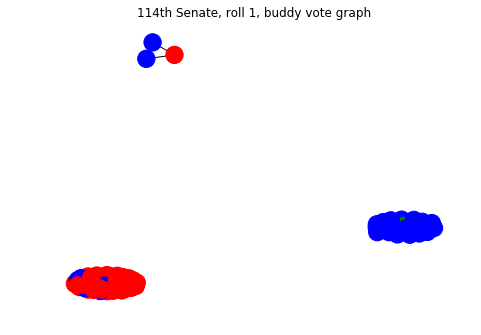

In [42]:
# Let's make a voteing graph
G = nx.Graph()

# grab voting data for a roll
cst, pty, mem = get_party_votes(114,1)

# for a roll, see which members voted alike
for i_m,i_c in zip(mem, cst):
    for j_m,j_c in zip(mem, cst):
        #print(i_m, i_c, j_m, j_c)
        if i_c == j_c:
            G.add_edge(i_m, j_m)

cm = buildCMap(G)
# Let's look at the graph
nx.draw(G,pos=nx.circular_layout(G),node_color=cm,with_labels=False)
#nx.draw_networkx_labels(G,pos=nx.spring_layout(G))
plt.title('114th Senate, roll 1, buddy vote graph')

In [43]:
# init save struct (just run once! or overwrite!!!)
if 0:
    fNameD = "buddyADJDict.p"
    pPthName = "/home/wade/Documents/Datasets/congressDicts/" + fNameD
    buddyADJDict = {}
    pickle.dump(buddyADJDict, open( pPthName, "wb" ) )
    print('Saved')

Saved


In [57]:
# build voting adj mats for one jk all senate session(s) jk 20 most recent
start = time.time()
sve = False
for congress in range(105,106):
    # congress = 114
    
    #num_rolls = len(set(vteSenThresh['rollnumber'])) # 502 rolls
    #num_sen = len(set(vteSenThresh['icpsr'])) # 100 
    num_rolls = getNumRolls('Senate', congress)
    num_sen = len(getMembers('Senate', congress))
    # (100 * 100) * 502 = 5020000
    # let's not use multiple matricies...
    
    print()
    print('Tabulating congress', congress, '|', num_rolls, 'rolls')

    # init mat
    buddyTallyMat = np.zeros((num_sen,num_sen))
    print('Building roll: ', end="")
    for roll in range(1, num_rolls+1):
        if roll % 100 == 0:
            print(roll,end=" ")

        # grab voting data for a roll
        cst, pty, mem = get_party_votes(congress,roll)
        print(len(mem), num_sen)

        # for a roll, see which members voted alike
        i_btm = 0
        for i_m,i_c in zip(mem, cst):
            j_btm = 0
            for j_m,j_c in zip(mem, cst):
                #print(i_m, i_c, j_m, j_c)
                if i_c == j_c:
                    # increment if they share a connection
                    buddyTallyMat[i_btm,j_btm] += 1
                j_btm += 1
            i_btm += 1  
    if sve:
        #save our hard work! + '_' +
        path = '/home/wade/codingCoop/congress/figs/senate_buddyroll_adjMats/'
        fname = path + str(congress) + '_r-all_ADJ-W.png' 
        plt.imshow(buddyTallyMat)
        tle = str(congress) + 'th Senate Voteing ADJ Mat (all votes)'
        plt.title(tle)
        plt.savefig(fname)

        # grab the adj dict
        fNameD = "buddyADJDict.p"
        pPthName = "/home/wade/Documents/Datasets/congressDicts/" + fNameD
        buddyADJDict = pickle.load( open( pPthName, "rb" ) )

        buddyADJDict[congress] = {}
        buddyADJDict[congress]['cst'] = cst
        buddyADJDict[congress]['pty'] = pty
        buddyADJDict[congress]['mem'] = mem
        buddyADJDict[congress]['vADJ'] = buddyTallyMat

        # save it again
        pickle.dump(buddyADJDict, open( pPthName, "wb" ) )
    
    
print('Took', (time.time() - start)) 
# Took 86.36s for 500 rolls, 1 congress
#plt.imshow(buddyTallyMat)

# these will need to be normalized somehow to account for the variable number of rolls?


Tabulating congress 105 | 612 rolls
Building roll: 101 100


IndexError: index 100 is out of bounds for axis 1 with size 100

In [58]:
# testing: do calls return the same members? 
# seems so... a def TODO: build a lookup f(x) to validate icpsr
if 0:
    cst1, pty1, mem1 = get_party_votes(114,1)
    cst2, pty2, mem2 = get_party_votes(114,60)

    print(mem1.head())
    print(mem2.head())
    print(list(mem1) == list(mem2))
# validation pt 2
if 1:
    for i in range(1,100):
        num_sen = len(getMembers('Senate', 104))
        cst, pty, mem = get_party_votes(104,i)
        print(len(mem),'|',num_sen,end=" ")

101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 101 | 103 

Text(0.5,1.05,'114th Senate Voteing ADJ Mat (all votes)')

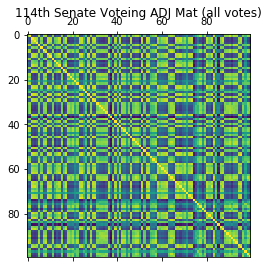

In [44]:
# hey this is pretty cool
plt.matshow(buddyTallyMat)
plt.title('114th Senate Voteing ADJ Mat (all votes)')

In [ ]:
# OLD STUFF

In [ ]:
# how do the party affiliations change over time? (Senate)
# very slow... 

thresh = 100 # select only a particular range of congress from 1 to 155. ie. 100 = 1988
vteSenThresh = vteSen[vteSen['congress']>=thresh]


ptyCnts = []
ptyBuff = []
currentCong = thresh
start = time.time()
print('Start...')
for index, row in vteSenThresh.iterrows():
    
    if index % 100000 == 0:
        print(int(row['congress']),currentCong)
    
    if int(row['congress']) != currentCong:
        print(currentCong,end=" ")
        currentCong = int(row['congress'])
        numPty = len(set(ptyBuff))
        #print(numPty)
        ptyCnts.append(numPty)
        ptyBuff = []
    
    isp = int(row['icpsr'])
    pty = getParty(isp)
    ptyBuff.append(pty[0])

    
    
    
    


In [ ]:
print(len(set(vteSen['congress'])))

ptyCnts
vteSenThresh = vteSen[vteSen['congress']>=thresh]

len(vteSenThresh)


In [ ]:
print('Num party Counts', ptyCnts)

if 1:
    plt.plot(ptyCnts)
    plt.title('Number of parties over time')
    plt.show()
    

In [ ]:
c1 = roll[roll['congress'] == 3]
max(c1['rollnumber'])

# collect max roll number for each congress
maxRolls = {}
for i in range(1, max(roll['congress'])):
    c = roll[roll['congress'] == i]
    maxRolls[i] = max(c['rollnumber'])

        

In [ ]:
x, y = zip(*maxRolls.items())
if 1:
    plt.plot(x,y)
    plt.title('Number of rolls per congress')
    plt.show()

In [ ]:
import RollCodes
rc = RollCodes.rollCodes # grab the data

In [ ]:
# calculate the yay nay ratio for n congress
import time

thresh = 75
df = roll[roll['congress'] > thresh]

start = time.time()
ynRat = []

compMin = (((max(df['congress'])-thresh) / 10) * 99) / 60
print('Thinking... (est time', compMin, ') minutes')
for i in range(min(df['congress']),max(df['congress'])):
    c = df[df['congress'] == i]

    yay,nay = 0,0
    for index, row in c.iterrows():
        if row['cast_code'] == 1:
            yay += 1
        elif row['cast_code'] == 6:
            nay += 1
            
    ynRat.append(yay/nay)
    
print('Took:', time.time()-start, 'seconds to run', max(df['congress']))
# takes 99 seconds to run 10
#       252               41 

In [ ]:
if 1:
    plt.plot(range(min(df['congress']),max(df['congress'])),ynRat)
    plt.title('yay/nay ratio per congress')
    plt.xlabel('Congress')
    plt.ylabel('ratio')
    plt.show()



In [ ]:
# Let's grab the names and parties
npty = pd.read_csv('data/ICPS.csv')
print(npty.head())
len(npty['icps'])

In [ ]:
# let's build some useful functions

def get_name(ipr):
    idx = npty[npty['icps'] == ipr].index.tolist()
    nms = [npty.loc[id_,'name'] for id_ in idx]
    return nms 

def get_party(ipr):
    idx = npty[npty['icps'] == str(ipr)].index.tolist()
    ptys = [npty.loc[id_,'party'] for id_ in idx]
    #ptys = [int(pt) for pt in ptys]
    
    ptys_ = []
    for p in ptys:
        if '*' in p: # deal with *
            ptys_.append(int(p[2:len(p)]))
        else:
            ptys_.append(int(p))
    return ptys_
    
# 1536

npty.loc[4,'state']

npty.loc[38,'name']
print(get_party(99911))
print(get_name(99911))

npty['icps'] == 99911

# 9094
npty.loc[9093,'icps']

len(npty[npty['icps'] == '99911'])
print(get_party(21166))

In [ ]:
# Let's find how one person votes over time

thresh = 110 
df = roll[roll['congress'] > thresh]
df.head()

# grab the votes for the member
memb = 1366
votes = [] #todo dict?
start = time.time()
for index, row in df.iterrows():
    if row['icpsr'] == memb:
        votes.append(row['cast_code'])

print('Number of votes for %f: %f' %(memb, len(votes)))

print('took', (time.time() - start))

plt.plot(votes)
plt.show()




In [ ]:
tst = df.head()
tst = tst.copy(deep=True)

tst['party'] = [1,0,0,1,1]

# add party to data

# make the party column
partys = []
for index, row in tst.iterrows():
    ptys = get_party(row['icpsr'])
    print(row['icpsr'], ptys)
    
    # there isn't a party
    if len(ptys) == 0:
        ptys = [999]
        
    partys.append(ptys[0])

In [ ]:
# how impoverished is my party data?
thresh = 110 
df = roll[roll['congress'] > thresh]

# grab unique icpsr's
members = df['icpsr'].unique()

pty = []
for mem in members:
    ptys = get_party(mem)
    
    if len(ptys) > 0:
        pty.append(ptys[0])
    #else:
        #print(mem)
        
print(len(pty),len(members))
print('took', (time.time() - start))
 
        
        

In [ ]:
npts = 300
max_iter = 100
 
X = np.linspace(-2, 1, 2 * npts)
Y = np.linspace(-1, 1, npts)
 
#broadcast X to a square array
C = X[:, None] + 1J * Y
#initial value is always zero
Z = np.zeros_like(C)
 
exit_times = max_iter * np.ones(C.shape, np.int32)
mask = exit_times > 0
 
for k in range(max_iter):
    Z[mask] = Z[mask] * Z[mask] + C[mask]
    mask, old_mask = abs(Z) < 2, mask
    #use XOR to detect the area which has changed 
    exit_times[mask ^ old_mask] = k
 
plt.imshow(exit_times.T,
           cmap=plt.cm.prism,
           extent=(X.min(), X.max(), Y.min(), Y.max()))

In [ ]:
# 



# are you more likely to see a yay after seeing a nay? Vice versa